In [41]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from functions import *

In [42]:
# Window version
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# M1 MAC version
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(DEVICE)

mps


In [43]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 15
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = 'CNN_deep'
dataset = "STL10"
save_model_path = f'/Users/euntaeklee/Git_Project/Pytorch/result/{model_type}_{dataset}.pt'

In [44]:
transform = transforms.ToTensor()
# CIFAR10 dataset
# train_DS = datasets.CIFAR10(root='/Users/euntaeklee/Git_Project/data', train=True, download=True, transform=transform)
# test_DS = datasets.CIFAR10(root='/Users/euntaeklee/Git_Project/data', train=False, download=True, transform=transform)
# STL10 dataset
train_DS = datasets.STL10(root='/Users/euntaeklee/Git_Project/data', split='train', download=True, transform=transform)
test_DS = datasets.STL10(root='/Users/euntaeklee/Git_Project/data', split='test', download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

100.0%


Extracting /Users/euntaeklee/Git_Project/data/stl10_binary.tar.gz to /Users/euntaeklee/Git_Project/data
Files already downloaded and verified


In [45]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

Dataset STL10
    Number of datapoints: 5000
    Root location: /Users/euntaeklee/Git_Project/data
    Split: train
    StandardTransform
Transform: ToTensor()
Dataset STL10
    Number of datapoints: 8000
    Root location: /Users/euntaeklee/Git_Project/data
    Split: test
    StandardTransform
Transform: ToTensor()
5000
8000


['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
torch.Size([32, 3, 96, 96])
car


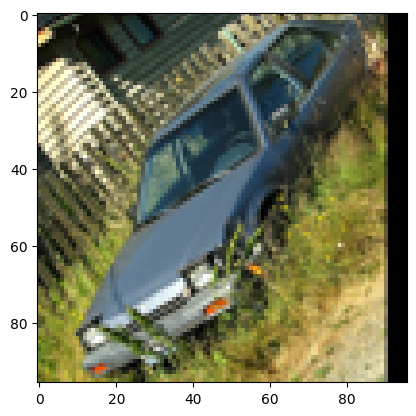

In [47]:
print(test_DS.classes)
# print(test_DS.class_to_idx)
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [48]:
# 1. change to tensor
# 2. change to "numxchannelxrowxcolumn"
# 3, change into 0 to 1 (int -> float)
print(type(train_DS.data))
print(train_DS.data.shape)
print(train_DS.data.dtype)
print(train_DS.data[0][0][0][0])
x_batch, y_batch = next(iter(train_DL)) # select one by using next(iter(train_DS))
print(type(x_batch))
print(x_batch.shape)
print(x_batch.dtype)
print(x_batch[0][0][0][0])

<class 'numpy.ndarray'>
(5000, 3, 96, 96)
uint8
146
<class 'torch.Tensor'>
torch.Size([32, 3, 96, 96])
torch.float32
tensor(0.)


In [49]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.maxp = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4,10)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.maxp(x)
        x = self.conv3(x)
        x = self.maxp(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.maxp = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.classifier = nn.Sequential(
            nn.Linear(128*12*12,512),
            nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxp(x)
        x = self.conv_block2(x)
        x = self.maxp(x)
        x = self.conv_block3(x)
        x = self.maxp(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return x

In [50]:
exec(f'model = {model_type}()')
print(model)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1,

Epoch: 1, Train loss: 5.189
------------------------------
Epoch: 2, Train loss: 1.73
------------------------------
Epoch: 3, Train loss: 1.503
------------------------------
Epoch: 4, Train loss: 1.378
------------------------------
Epoch: 5, Train loss: 1.248
------------------------------
Epoch: 6, Train loss: 1.172
------------------------------
Epoch: 7, Train loss: 1.077
------------------------------
Epoch: 8, Train loss: 1.001
------------------------------
Epoch: 9, Train loss: 0.93
------------------------------
Epoch: 10, Train loss: 0.854
------------------------------
Epoch: 11, Train loss: 0.769
------------------------------
Epoch: 12, Train loss: 0.718
------------------------------
Epoch: 13, Train loss: 0.649
------------------------------
Epoch: 14, Train loss: 0.561
------------------------------
Epoch: 15, Train loss: 0.53
------------------------------


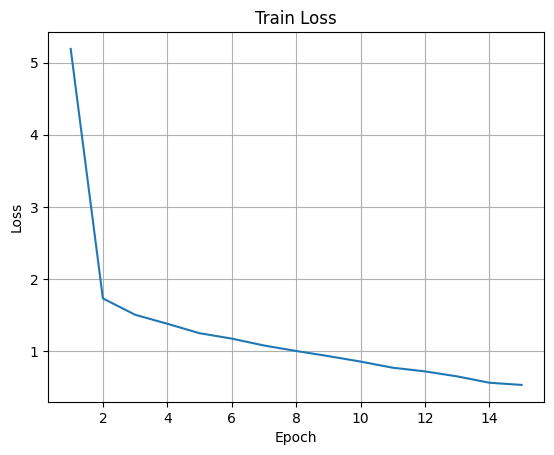

In [51]:
if new_model_train:
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.grid()

In [52]:
load_model = torch.load(save_model_path)

In [53]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 57.1125/8000 (57.11) %
9915626


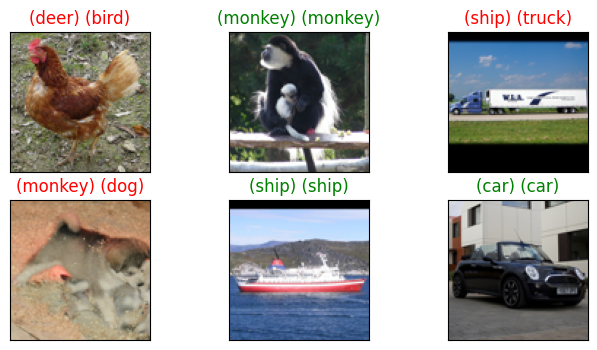

In [54]:
Test_plot(load_model, test_DL)